## Zooming for Self Driving? 

##### Dependency Imports

In [1]:
# Import dependencies
import numpy as np
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.buffers import RolloutBuffer
from stable_baselines3.common.utils import obs_as_tensor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.distributions import CategoricalDistribution
from stable_baselines3.common.type_aliases import Schedule

from typing import Dict, List, Tuple, Optional, Any, ClassVar, Type, TypeVar, Union

import torch as th
import torch.nn as nn

import warnings

import highway_env # original HighwayEnv repo

c:\Users\Polar\miniconda3\envs\highway\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


##### Understanding State Space

In [2]:
env = gym.make(
    "highway-fast-v0",
    render_mode="rgb_array",
    config={
        "action": {
            "type": "ContinuousAction",
            "steering_range": [-np.pi/4, np.pi/4],
            "longitudinal": False,  # No throttle control
            "lateral": True,        # Steering only
        },
        "duration": 40,
        "policy_frequency": 2,  # Control at 2 Hz
    }
)

observation (i.e. state): 
 [[ 1.          0.82268095  0.          0.3125      0.        ]
 [ 1.          0.0957897   0.         -0.05685878  0.        ]
 [ 1.          0.21342634  0.33333334 -0.0229109   0.        ]
 [ 1.          0.3342094   0.         -0.04790085  0.        ]
 [ 1.          0.45183605  0.6666667  -0.05033796  0.        ]] 

reward: 
 0.7999999999999999 

done: 
 False 

truncated: 
 False 

info: 
 {'speed': 25.0, 'crashed': False, 'action': array([0.]), 'rewards': {'collision_reward': 0.0, 'right_lane_reward': 0.0, 'high_speed_reward': np.float64(0.5), 'on_road_reward': 1.0}} 



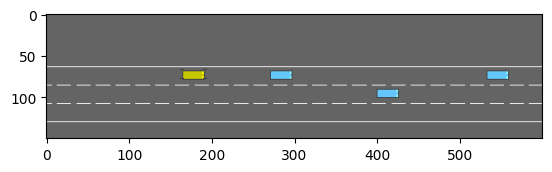

In [3]:
from matplotlib import pyplot as plt
env.reset()
action = np.array([0.0])
obs, reward, done, truncated, info = env.step(action)
print(f"observation (i.e. state): \n {obs} \n")
print(f"reward: \n {reward} \n")
print(f"done: \n {done} \n")
print(f"truncated: \n {truncated} \n")
print(f"info: \n {info} \n")

plt.imshow(env.render())
plt.show()

#### I. Class/Function Definitions

##### Masked PPO Policy

In [4]:
# Masked PPO Policy
class MaskedCategoricalDistribution(CategoricalDistribution):
    """
    Categorical distribution with action masking support.

    Invalid actions (masked) are given probability 0.
    """

    def __init__(self, action_dim: int):
        super().__init__(action_dim)
        self.action_mask: Optional[th.Tensor] = None

    def proba_distribution_net(self, latent_dim: int) -> nn.Module:
        """Create the action distribution network."""
        return nn.Linear(latent_dim, self.action_dim)

    def proba_distribution(
        self,
        action_logits: th.Tensor,
        action_mask: Optional[th.Tensor] = None,
    ) -> "MaskedCategoricalDistribution":
        """
        Set the action logits and apply masking.

        Args:
            action_logits: Logits for each action (batch_size, n_actions)
            action_mask: Boolean mask where True = invalid (batch_size, n_actions)
        """
        self.action_mask = action_mask

        if action_mask is not None:
            # Set masked action logits to very large negative value
            # This makes their probability effectively 0 after softmax
            action_logits = th.where(
                action_mask,
                th.tensor(float("-inf"), device=action_logits.device, dtype=action_logits.dtype),
                action_logits,
            )

        self.distribution = th.distributions.Categorical(logits=action_logits)
        return self

    def log_prob(self, actions: th.Tensor) -> th.Tensor:
        """Get log probability of actions."""
        return self.distribution.log_prob(actions)

    def entropy(self) -> th.Tensor:
        """Get entropy of the distribution."""
        return self.distribution.entropy()

    def sample(self) -> th.Tensor:
        """Sample an action from the distribution."""
        return self.distribution.sample()

    def mode(self) -> th.Tensor:
        """Return the most likely action (greedy)."""
        return th.argmax(self.distribution.probs, dim=-1)

    def actions_from_params(
        self,
        action_logits: th.Tensor,
        action_mask: Optional[th.Tensor] = None,
        deterministic: bool = False,
    ) -> th.Tensor:
        """
        Sample actions from the distribution.

        Args:
            action_logits: Logits for each action
            action_mask: Boolean mask where True = invalid
            deterministic: If True, return mode instead of sampling
        """
        self.proba_distribution(action_logits, action_mask)
        if deterministic:
            return self.mode()
        return self.sample()

    def log_prob_from_params(
        self,
        action_logits: th.Tensor,
        action_mask: Optional[th.Tensor] = None,
    ) -> Tuple[th.Tensor, th.Tensor]:
        """
        Sample actions and get their log probabilities.

        Returns:
            actions: Sampled actions
            log_probs: Log probabilities of sampled actions
        """
        actions = self.actions_from_params(action_logits, action_mask)
        log_prob = self.log_prob(actions)
        return actions, log_prob


class MaskedActorCriticPolicy(ActorCriticPolicy):
    """
    Actor-Critic policy with action masking support for PPO.

    This policy can handle dynamic action masks provided through the info dict.
    """

    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Schedule,
        **kwargs,
    ):
        # We'll override the action distribution
        self.use_action_masking = True
        super().__init__(observation_space, action_space, lr_schedule, **kwargs)

    def _build(self, lr_schedule: Schedule) -> None:
        """
        Create the networks and the optimizer.

        Override to use masked distribution.
        """
        super()._build(lr_schedule)

        # Replace the action distribution with our masked version
        if isinstance(self.action_space, spaces.Discrete):
            self.action_dist = MaskedCategoricalDistribution(self.action_space.n)
            self.action_net = self.action_dist.proba_distribution_net(self.mlp_extractor.latent_dim_pi)

    def _get_action_dist_from_latent(
        self,
        latent_pi: th.Tensor,
        action_masks: Optional[th.Tensor] = None,
    ) -> MaskedCategoricalDistribution:
        """
        Get action distribution from latent policy representation.

        Args:
            latent_pi: Latent representation from policy network
            action_masks: Optional action masks (True = invalid)
        """
        action_logits = self.action_net(latent_pi)
        # Create a new distribution instance with the logits and masks
        dist = MaskedCategoricalDistribution(self.action_space.n)
        return dist.proba_distribution(action_logits, action_masks)

    def forward(
        self,
        obs: th.Tensor,
        deterministic: bool = False,
        action_masks: Optional[th.Tensor] = None,
    ) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        """
        Forward pass in all networks (actor and critic).

        Args:
            obs: Observation
            deterministic: Whether to sample or use deterministic actions
            action_masks: Action masks (True = invalid)

        Returns:
            actions: Selected actions
            values: Estimated values
            log_probs: Log probability of actions
        """
        # Preprocess the observation if needed
        features = self.extract_features(obs)
        if self.share_features_extractor:
            latent_pi, latent_vf = self.mlp_extractor(features)
        else:
            pi_features, vf_features = features
            latent_pi = self.mlp_extractor.forward_actor(pi_features)
            latent_vf = self.mlp_extractor.forward_critic(vf_features)

        # Evaluate the values for the given observations
        values = self.value_net(latent_vf)

        # Get action distribution with masking
        distribution = self._get_action_dist_from_latent(latent_pi, action_masks)

        # Sample actions
        if deterministic:
            actions = distribution.mode()
        else:
            actions = distribution.sample()

        log_prob = distribution.log_prob(actions)
        actions = actions.reshape((-1,) + self.action_space.shape)

        return actions, values, log_prob

    def evaluate_actions(
        self,
        obs: th.Tensor,
        actions: th.Tensor,
        action_masks: Optional[th.Tensor] = None,
    ) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        """
        Evaluate actions according to the current policy.

        Args:
            obs: Observation
            actions: Actions to evaluate
            action_masks: Action masks (True = invalid)

        Returns:
            values: Estimated values
            log_probs: Log probability of actions
            entropy: Entropy of the distribution
        """
        # Preprocess the observation if needed
        features = self.extract_features(obs)
        if self.share_features_extractor:
            latent_pi, latent_vf = self.mlp_extractor(features)
        else:
            pi_features, vf_features = features
            latent_pi = self.mlp_extractor.forward_actor(pi_features)
            latent_vf = self.mlp_extractor.forward_critic(vf_features)

        # Evaluate values
        values = self.value_net(latent_vf)

        # Get action distribution with masking
        distribution = self._get_action_dist_from_latent(latent_pi, action_masks)

        # Evaluate log probabilities and entropy
        log_prob = distribution.log_prob(actions)
        entropy = distribution.entropy()

        return values, log_prob, entropy

    def predict_values(
        self,
        obs: th.Tensor,
    ) -> th.Tensor:
        """
        Get the estimated values according to the current policy.

        Args:
            obs: Observation

        Returns:
            Estimated values
        """
        features = self.extract_features(obs)
        if self.share_features_extractor:
            _, latent_vf = self.mlp_extractor(features)
        else:
            _, vf_features = features
            latent_vf = self.mlp_extractor.forward_critic(vf_features)
        return self.value_net(latent_vf)

    def _predict(
        self,
        observation: th.Tensor,
        deterministic: bool = False,
        action_masks: Optional[th.Tensor] = None,
    ) -> th.Tensor:
        """
        Get the action according to the policy for a given observation.

        Args:
            observation: Observation
            deterministic: Whether to use stochastic or deterministic actions
            action_masks: Action masks (True = invalid)

        Returns:
            Taken action
        """
        actions, _, _ = self.forward(observation, deterministic, action_masks)
        return actions


class MaskedPPOPolicy(MaskedActorCriticPolicy):
    """
    Policy class for PPO with action masking.
    Alias for MaskedActorCriticPolicy for consistency with SB3 naming.
    """
    pass

In [5]:
# Test the masked distribution
print("Testing MaskedCategoricalDistribution...")

n_actions = 100
batch_size = 4

dist = MaskedCategoricalDistribution(n_actions)

# Create some dummy logits
logits = th.randn(batch_size, n_actions)

# Create a mask: first half of actions are valid, second half invalid
mask = th.zeros(batch_size, n_actions, dtype=th.bool)
mask[:, 50:] = True  # Mask second half

# Test distribution
dist.proba_distribution(logits, mask)

# Sample actions
actions = dist.sample()
print(f"Sampled actions: {actions}")
print(f"All actions < 50: {th.all(actions < 50)}")  # Should be True

# Test log probs
log_probs = dist.log_prob(actions)
print(f"Log probs shape: {log_probs.shape}")

# Test entropy
entropy = dist.entropy()
print(f"Entropy shape: {entropy.shape}")

print("\nMasked distribution test passed!")

Testing MaskedCategoricalDistribution...
Sampled actions: tensor([18, 41, 13, 28])
All actions < 50: True
Log probs shape: torch.Size([4])
Entropy shape: torch.Size([4])

Masked distribution test passed!


##### Action space definition

In [6]:
# Action space definition
class AdaptiveSteeringActionSpace:
    """
    Manages adaptive action masking for steering control with pruning.

    The action space is a 1D grid over steering angles.
    Actions are gradually unmasked based on advantages, and low-performing actions are pruned.
    """

    def __init__(
        self,
        steering_range: Tuple[float, float] = (-np.pi/4, np.pi/4),
        final_grid_size: int = 20,
        initial_active_actions: int = 5,
        unmask_rate: float = 0.2,  # Fraction of masked actions to unmask per update
        prune_rate: float = 0.1,  # Fraction of active actions to prune per update
        advantage_threshold: float = 0.0,  # Minimum advantage to trigger unmasking
        min_samples_for_pruning: int = 50,  # Minimum samples before considering pruning
    ):
        """
        Args:
            steering_range: (min, max) steering angle in radians
            final_grid_size: Total number of discrete steering angles
            initial_active_actions: Number of actions initially active
            unmask_rate: Fraction of masked actions to unmask per update
            prune_rate: Fraction of active actions to consider for pruning per update
            advantage_threshold: Minimum advantage for an action to trigger unmasking neighbors
            min_samples_for_pruning: Minimum times an action must be sampled before pruning
        """
        self.steering_range = steering_range
        self.final_grid_size = final_grid_size
        self.initial_active_actions = initial_active_actions
        self.unmask_rate = unmask_rate
        self.prune_rate = prune_rate
        self.advantage_threshold = advantage_threshold
        self.min_samples_for_pruning = min_samples_for_pruning

        # Create the full action space
        self.n_actions = final_grid_size
        self.steering_values = np.linspace(steering_range[0], steering_range[1], final_grid_size)

        # Initialize mask: True = masked (invalid), False = unmasked (valid)
        self.action_mask = np.ones(self.n_actions, dtype=bool)

        # Initialize with sparse uniform grid
        self._initialize_sparse_grid()

        # Track action statistics
        self.action_advantages = np.zeros(self.n_actions)
        self.action_counts = np.zeros(self.n_actions)

    def _initialize_sparse_grid(self):
        """Initialize with a uniform sparse grid matching initial_active_actions."""
        if self.initial_active_actions >= self.final_grid_size:
            # If we want all actions initially, unmask everything
            self.action_mask[:] = False
        else:
            # Distribute initial actions uniformly
            indices = np.linspace(0, self.final_grid_size - 1, self.initial_active_actions, dtype=int)
            self.action_mask[indices] = False

    def get_valid_actions(self) -> np.ndarray:
        """Returns array of valid (unmasked) action indices."""
        return np.where(~self.action_mask)[0]

    def get_action_mask(self) -> np.ndarray:
        """Returns boolean mask where True = invalid/masked."""
        return self.action_mask.copy()

    def get_steering_value(self, action_idx: int) -> float:
        """Convert action index to steering angle value."""
        # Handle numpy arrays
        if isinstance(action_idx, np.ndarray):
            action_idx = int(action_idx.item())
        else:
            action_idx = int(action_idx)

        return self.steering_values[action_idx]

    def update_advantages(self, action_indices: np.ndarray, advantages: np.ndarray):
        """
        Update running statistics for action advantages.

        Args:
            action_indices: Array of action indices taken
            advantages: Corresponding advantage estimates
        """
        action_indices = action_indices.astype(int).flatten()
        advantages = advantages.flatten()

        for action_idx, advantage in zip(action_indices, advantages):
            self.action_advantages[action_idx] += advantage
            self.action_counts[action_idx] += 1

    def get_average_advantages(self) -> np.ndarray:
        """Get average advantage for each action (0 if never taken)."""
        avg_advantages = np.zeros(self.n_actions)
        valid = self.action_counts > 0
        avg_advantages[valid] = self.action_advantages[valid] / self.action_counts[valid]
        return avg_advantages

    def _get_neighbors(self, action_idx: int) -> List[int]:
        """Get neighboring action indices (left and right)."""
        neighbors = []
        # Left neighbor
        if action_idx > 0:
            neighbors.append(action_idx - 1)
        # Right neighbor
        if action_idx < self.n_actions - 1:
            neighbors.append(action_idx + 1)
        return neighbors

    def unmask_and_prune(self):
        """
        Gradually unmask new actions near high-advantage actions,
        and prune low-performing actions to maintain constant active action count.
        """
        target_active = self.initial_active_actions
        current_active = self.get_num_valid_actions()

        avg_advantages = self.get_average_advantages()
        valid_actions = self.get_valid_actions()

        # Step 1: Identify candidates for pruning (low advantage, sufficient samples)
        prune_candidates = []
        for action_idx in valid_actions:
            if self.action_counts[action_idx] >= self.min_samples_for_pruning:
                prune_candidates.append((action_idx, avg_advantages[action_idx]))

        # Step 2: Identify candidates for unmasking (neighbors of high-advantage actions)
        unmask_candidates = set()

        # Find high-advantage actions
        high_advantage_actions = []
        for action_idx in valid_actions:
            if avg_advantages[action_idx] > self.advantage_threshold:
                high_advantage_actions.append(action_idx)

        if len(high_advantage_actions) == 0 and len(valid_actions) > 0:
            # If no high-advantage actions, use the best available
            best_action = valid_actions[np.argmax(avg_advantages[valid_actions])]
            high_advantage_actions = [best_action]

        # Collect masked neighbors of high-advantage actions
        for action_idx in high_advantage_actions:
            neighbors = self._get_neighbors(action_idx)
            for neighbor_idx in neighbors:
                if self.action_mask[neighbor_idx]:  # Currently masked
                    unmask_candidates.add(neighbor_idx)

        # Step 3: Determine how many to unmask and prune
        n_to_unmask = int(len(unmask_candidates) * self.unmask_rate) if len(unmask_candidates) > 0 else 0
        n_to_unmask = max(1, min(n_to_unmask, len(unmask_candidates)))

        # We want to maintain approximately target_active actions
        # If we unmask n_to_unmask, we should prune the same amount (or prune first then unmask)
        n_to_prune = 0
        if len(prune_candidates) > 0:
            # Prune roughly the same number we're unmasking to maintain constant L1 norm
            n_to_prune = min(n_to_unmask, int(len(prune_candidates) * self.prune_rate))
            n_to_prune = max(0, n_to_prune)
            # Don't prune so much that we go below target
            n_to_prune = min(n_to_prune, current_active - target_active + n_to_unmask)

        # Step 4: Prune low-performing actions first
        if n_to_prune > 0 and len(prune_candidates) > 0:
            # Sort by advantage (lowest first)
            prune_candidates.sort(key=lambda x: x[1])
            to_prune = [action_idx for action_idx, _ in prune_candidates[:n_to_prune]]

            for action_idx in to_prune:
                self.action_mask[action_idx] = True  # Mask (prune) the action

        # Step 5: Unmask new actions
        if n_to_unmask > 0 and len(unmask_candidates) > 0:
            unmask_list = list(unmask_candidates)
            to_unmask = np.random.choice(unmask_list, size=min(n_to_unmask, len(unmask_list)), replace=False)

            for action_idx in to_unmask:
                self.action_mask[action_idx] = False  # Unmask

    def get_num_valid_actions(self) -> int:
        """Returns the current number of valid (unmasked) actions."""
        return np.sum(~self.action_mask)

    def get_progress(self) -> float:
        """Returns the fraction of actions that have been explored (0 to 1)."""
        # Progress isn't just about unmasked count, but about exploration
        # We define progress as the fraction of actions that have been sampled at least once
        return np.sum(self.action_counts > 0) / self.n_actions

    def reset_statistics(self):
        """Reset advantage and count statistics (use if needed for episodic tracking)."""
        self.action_advantages = np.zeros(self.n_actions)
        self.action_counts = np.zeros(self.n_actions)


class AdaptiveSteeringActionWrapper(gym.Wrapper):
    """
    Gym wrapper that converts the adaptive discrete steering actions to continuous steering
    for highway-env, while handling action masking.
    """

    def __init__(
        self,
        env: gym.Env,
        adaptive_action_space: AdaptiveSteeringActionSpace,
    ):
        """
        Args:
            env: Highway-env environment configured with ContinuousAction (steering only)
            adaptive_action_space: AdaptiveSteeringActionSpace instance managing the masking
        """
        super().__init__(env)
        self.adaptive_space = adaptive_action_space

        # Override the action space to be discrete with the full action count
        self.action_space = gym.spaces.Discrete(self.adaptive_space.n_actions)

    def step(self, action: int):
        """Convert discrete action to continuous steering and step environment."""
        # Convert discrete action to steering angle
        steering = self.adaptive_space.get_steering_value(action)

        # Map to [-1, 1] range expected by ContinuousAction
        steering_norm = self._map_to_normalized(steering, self.adaptive_space.steering_range)

        # For steering-only control, we use 0 acceleration (let the car maintain speed)
        continuous_action = np.array([steering_norm])
        return self.env.step(continuous_action)

    def _map_to_normalized(self, value: float, range_: Tuple[float, float]) -> float:
        """Map a value from a range to [-1, 1]."""
        return 2 * (value - range_[0]) / (range_[1] - range_[0]) - 1

    def get_action_mask(self) -> np.ndarray:
        """Get current action mask for the policy."""
        return self.adaptive_space.get_action_mask()


In [7]:
# Test adaptive speering space
adaptive_space = AdaptiveSteeringActionSpace(
    steering_range=(-np.pi/4, np.pi/4),
    final_grid_size=20,
    initial_active_actions=5,
    unmask_rate=0.2,
    prune_rate=0.1,
)

print(f"Total actions: {adaptive_space.n_actions}")
print(f"Initial valid actions: {adaptive_space.get_num_valid_actions()}")
print(f"Valid action indices: {adaptive_space.get_valid_actions()}")
print(f"Steering values: {[adaptive_space.get_steering_value(i) for i in adaptive_space.get_valid_actions()]}")

# Simulate some advantages
valid_actions = adaptive_space.get_valid_actions()
action_indices = np.random.choice(valid_actions, size=100)
advantages = np.random.randn(100)

adaptive_space.update_advantages(action_indices, advantages)
print(f"\nAverage advantages computed")

# Unmask and prune
print(f"\nBefore unmask/prune: {adaptive_space.get_num_valid_actions()} valid actions")
adaptive_space.unmask_and_prune()
print(f"After unmask/prune: {adaptive_space.get_num_valid_actions()} valid actions")
print(f"Valid action indices: {adaptive_space.get_valid_actions()}")
print(f"Progress: {adaptive_space.get_progress():.2%}")

Total actions: 20
Initial valid actions: 5
Valid action indices: [ 0  4  9 14 19]
Steering values: [np.float64(-0.7853981633974483), np.float64(-0.4547041998616806), np.float64(-0.04133674544197097), np.float64(0.3720307089777386), np.float64(0.7853981633974483)]

Average advantages computed

Before unmask/prune: 5 valid actions
After unmask/prune: 6 valid actions
Valid action indices: [ 0  3  4  9 14 19]
Progress: 25.00%


##### Zooming Implementation

In [25]:
# Zooming PPO implementation
SelfAdaptivePPO = TypeVar("SelfAdaptivePPO", bound="AdaptivePPO")


class AdaptiveRolloutBuffer(RolloutBuffer):
    """
    Extended rollout buffer that also stores action masks.
    """

    def __init__(self, *args, **kwargs):
        self.action_masks = None
        super().__init__(*args, **kwargs)

    def reset(self) -> None:
        super().reset()
        if self.action_masks is not None:
            self.action_masks = np.zeros(
                (self.buffer_size, self.n_envs, self.action_masks.shape[-1]),
                dtype=np.bool_,
            )

    def add(
        self,
        *args,
        action_masks: Optional[np.ndarray] = None,
        **kwargs,
    ) -> None:
        """
        Add elements to the buffer, including action masks.
        """
        # Initialize action_masks buffer on first add if provided
        if action_masks is not None and self.action_masks is None:
            self.action_masks = np.zeros(
                (self.buffer_size, self.n_envs, action_masks.shape[-1]),
                dtype=np.bool_,
            )

        # Store action masks
        if action_masks is not None:
            self.action_masks[self.pos] = action_masks.copy()

        # Call parent add
        super().add(*args, **kwargs)

    # Don't override get() - just use parent implementation
    # We'll handle action masks separately in the training loop


class AdaptivePPO(PPO):
    """
    PPO with adaptive action space unmasking.

    This algorithm gradually unmasks new actions during training based on
    advantage estimates, allowing the agent to explore finer-grained actions
    as it learns.
    """

    policy_aliases: ClassVar[Dict[str, Type[MaskedPPOPolicy]]] = {
        "MaskedMlpPolicy": MaskedPPOPolicy,
    }

    def __init__(
        self,
        policy: Union[str, Type[MaskedPPOPolicy]],
        env: GymEnv,
        adaptive_action_space: AdaptiveSteeringActionSpace,
        unmask_frequency: int = 10,  # Unmask every N policy updates
        *args,
        **kwargs,
    ):
        """
        Args:
            policy: Policy type or string alias
            env: Environment
            adaptive_action_space: AdaptiveActionSpace instance managing masking
            unmask_frequency: How often to unmask new actions (in policy updates)
            *args, **kwargs: Additional arguments for PPO
        """
        self.adaptive_action_space = adaptive_action_space
        self.unmask_frequency = unmask_frequency
        self._num_policy_updates = 0

        # Override default policy if using string
        if isinstance(policy, str) and policy == "MlpPolicy":
            policy = "MaskedMlpPolicy"

        super().__init__(policy, env, *args, **kwargs)

        # Track advantages per action for unmasking
        self.action_advantages_buffer = []

    @classmethod
    def load(
        cls,
        path: str,
        env: Optional[GymEnv] = None,
        device: Union[th.device, str] = "auto",
        custom_objects: Optional[Dict[str, Any]] = None,
        print_system_info: bool = False,
        force_reset: bool = True,
        **kwargs,
    ):
        """
        Load the model from a zip-file.

        This overrides the parent load() to handle the adaptive_action_space parameter.

        Args:
            path: Path to the file (or a file-like) where to load the agent from
            env: Environment that the model was trained on. Must be provided.
            device: Device on which the code should run
            custom_objects: Dictionary of custom objects to replace on load
            print_system_info: Whether to print system info
            force_reset: Force a call to reset() before training
            **kwargs: Additional keyword arguments (must include 'adaptive_action_space')

        Returns:
            Loaded model
        """
        if env is None:
            raise ValueError("env must be provided when loading AdaptivePPO")

        # Get adaptive_action_space from kwargs or custom_objects
        if "adaptive_action_space" not in kwargs:
            if custom_objects is not None and "adaptive_action_space" in custom_objects:
                kwargs["adaptive_action_space"] = custom_objects["adaptive_action_space"]
            else:
                raise ValueError("adaptive_action_space must be provided when loading AdaptivePPO")

        adaptive_action_space = kwargs["adaptive_action_space"]
        unmask_frequency = kwargs.get("unmask_frequency", 10)

        # Load as a regular PPO model first (just to get the saved data)
        import zipfile
        import json
        import pathlib

        # Add .zip extension if not present
        if not path.endswith(".zip"):
            path = path + ".zip"

        # Load the data from the zip file
        with zipfile.ZipFile(path, "r") as archive:
            # Load the parameters
            data_json = archive.read("data").decode("utf-8")
            data = json.loads(data_json)

        # Get hyperparameters from saved data if available
        learning_rate = data.get("learning_rate", 5e-4)
        n_steps = data.get("n_steps", 128)
        batch_size = data.get("batch_size", 64)
        n_epochs = data.get("n_epochs", 10)
        gamma = data.get("gamma", 0.9)
        gae_lambda = data.get("gae_lambda", 0.95)

        # Create a new model with the adaptive_action_space
        model = cls(
            policy="MaskedMlpPolicy",
            env=env,
            adaptive_action_space=adaptive_action_space,
            unmask_frequency=unmask_frequency,
            learning_rate=learning_rate,
            n_steps=n_steps,
            batch_size=batch_size,
            n_epochs=n_epochs,
            gamma=gamma,
            gae_lambda=gae_lambda,
            verbose=0,
        )

        # Now load the parameters (network weights)
        model.set_parameters(load_path_or_dict=path, device=device)

        return model

    def _setup_model(self) -> None:
        """Setup the model and replace rollout buffer with adaptive version."""
        super()._setup_model()

        # Replace rollout buffer with adaptive version
        self.rollout_buffer = AdaptiveRolloutBuffer(
            self.n_steps,
            self.observation_space,
            self.action_space,
            device=self.device,
            gamma=self.gamma,
            gae_lambda=self.gae_lambda,
            n_envs=self.n_envs,
        )

    def collect_rollouts(
        self,
        env,
        callback,
        rollout_buffer,
        n_rollout_steps: int,
    ) -> bool:
        """
        Collect experiences using the current policy and fill the rollout buffer.
        Modified to include action masks.
        """
        assert self._last_obs is not None, "No previous observation was provided"

        # Switch to eval mode
        self.policy.set_training_mode(False)

        n_steps = 0
        rollout_buffer.reset()

        callback.on_rollout_start()

        while n_steps < n_rollout_steps:
            with th.no_grad():
                # Convert to pytorch tensor
                obs_tensor = obs_as_tensor(self._last_obs, self.device)

                # Get current action mask
                action_mask = self.adaptive_action_space.get_action_mask()
                # Expand mask for each environment
                action_mask_batch = np.tile(action_mask, (self.n_envs, 1))
                action_mask_tensor = th.as_tensor(action_mask_batch, device=self.device)

                # Get actions with masking
                actions, values, log_probs = self.policy.forward(
                    obs_tensor,
                    deterministic=False,
                    action_masks=action_mask_tensor,
                )

            actions = actions.cpu().numpy()

            # Rescale and perform action
            clipped_actions = actions

            # Clip the actions to avoid out of bound error
            from gymnasium import spaces as gym_spaces
            if isinstance(self.action_space, gym_spaces.Box):
                clipped_actions = np.clip(actions, self.action_space.low, self.action_space.high)

            new_obs, rewards, dones, infos = env.step(clipped_actions)

            self.num_timesteps += self.n_envs

            # Give access to local variables
            callback.update_locals(locals())
            if not callback.on_step():
                return False

            self._update_info_buffer(infos, dones)
            n_steps += 1

            if isinstance(self.action_space, gym_spaces.Discrete):
                # Reshape in case of discrete action
                actions = actions.reshape(-1, 1)

            # Handle timeout by bootstrapping with value function
            for idx, done in enumerate(dones):
                if (
                    done
                    and infos[idx].get("terminal_observation") is not None
                    and infos[idx].get("TimeLimit.truncated", False)
                ):
                    terminal_obs = self.policy.obs_to_tensor(infos[idx]["terminal_observation"])[0]
                    with th.no_grad():
                        terminal_value = self.policy.predict_values(terminal_obs)[0]
                    rewards[idx] += self.gamma * terminal_value

            # Add to buffer with action masks
            rollout_buffer.add(
                self._last_obs,
                actions,
                rewards,
                self._last_episode_starts,
                values,
                log_probs,
                action_masks=action_mask_batch,
            )
            self._last_obs = new_obs
            self._last_episode_starts = dones

        # Compute value for the last timestep
        with th.no_grad():
            obs_tensor = obs_as_tensor(new_obs, self.device)
            values = self.policy.predict_values(obs_tensor)

        rollout_buffer.compute_returns_and_advantage(last_values=values, dones=dones)

        callback.on_rollout_end()

        return True

    def train(self) -> None:
        """
        Update policy using the currently gathered rollout buffer.
        Modified to use action masks and track advantages for unmasking.
        """
        # Switch to train mode
        self.policy.set_training_mode(True)

        # Update optimizer learning rate
        self._update_learning_rate(self.policy.optimizer)

        # Compute current clip range
        clip_range = self.clip_range(self._current_progress_remaining)

        # Optional: clip range for the value function
        if self.clip_range_vf is not None:
            clip_range_vf = self.clip_range_vf(self._current_progress_remaining)

        entropy_losses = []
        pg_losses, value_losses = [], []
        clip_fractions = []

        continue_training = True

        # Track advantages for unmasking
        all_actions = []
        all_advantages = []

        # Train for n_epochs epochs
        for epoch in range(self.n_epochs):
            approx_kl_divs = []

            # Do a complete pass on the rollout buffer
            for rollout_data in self.rollout_buffer.get(self.batch_size):
                actions = rollout_data.actions
                observations = rollout_data.observations
                old_values = rollout_data.old_values
                old_log_prob = rollout_data.old_log_prob
                advantages = rollout_data.advantages
                returns = rollout_data.returns

                # Get current action mask (same for all samples in this training iteration)
                action_mask = self.adaptive_action_space.get_action_mask()
                batch_size_current = observations.shape[0]
                action_mask_batch = np.tile(action_mask, (batch_size_current, 1))
                action_masks = th.as_tensor(action_mask_batch, device=self.device)

                # Store for unmasking
                all_actions.append(actions.cpu().numpy())
                all_advantages.append(advantages.cpu().numpy())

                from gymnasium import spaces as gym_spaces
                if isinstance(self.action_space, gym_spaces.Discrete):
                    # Convert discrete action from float to long
                    actions = actions.long().flatten()

                # Re-sample policy and value
                values, log_prob, entropy = self.policy.evaluate_actions(
                    observations,
                    actions,
                    action_masks=action_masks,
                )

                #! TODO: Label and delete later
                print(values)
                print(log_prob)
                print(entropy) 

                values = values.flatten()

                # Normalize advantage
                advantages = advantages.flatten()
                if self.normalize_advantage and len(advantages) > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # Ratio between old and new policy
                ratio = th.exp(log_prob - old_log_prob)

                # Clipped surrogate loss
                policy_loss_1 = advantages * ratio
                policy_loss_2 = advantages * th.clamp(ratio, 1 - clip_range, 1 + clip_range)
                policy_loss = -th.min(policy_loss_1, policy_loss_2).mean()

                # Logging
                pg_losses.append(policy_loss.item())
                clip_fraction = th.mean((th.abs(ratio - 1) > clip_range).float()).item()
                clip_fractions.append(clip_fraction)

                if self.clip_range_vf is None:
                    # No clipping
                    values_pred = values
                else:
                    # Clip the difference between old and new value
                    values_pred = old_values + th.clamp(
                        values - old_values, -clip_range_vf, clip_range_vf
                    )

                # Value loss
                value_loss = th.nn.functional.mse_loss(returns, values_pred)
                value_losses.append(value_loss.item())

                # Entropy loss favor exploration
                if entropy is None:
                    entropy_loss = -th.mean(-log_prob)
                else:
                    entropy_loss = -th.mean(entropy)

                entropy_losses.append(entropy_loss.item())

                loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss

                # Optimization step
                self.policy.optimizer.zero_grad()
                loss.backward()

                # Clip grad norm
                th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.policy.optimizer.step()
                approx_kl_divs.append(th.mean(old_log_prob - log_prob).detach().cpu().numpy())
                #! TODO: remove break (only does one iteration)
                break

            self._n_updates += 1
            if not continue_training:
                break

        # Update adaptive action space based on advantages
        self._num_policy_updates += 1
        if self._num_policy_updates % self.unmask_frequency == 0:
            self._update_action_space(all_actions, all_advantages)

        # Log training metrics
        explained_var = self._explained_variance(
            self.rollout_buffer.values.flatten(),
            self.rollout_buffer.returns.flatten(),
        )

        # Logging
        self.logger.record("train/entropy_loss", np.mean(entropy_losses))
        self.logger.record("train/policy_gradient_loss", np.mean(pg_losses))
        self.logger.record("train/value_loss", np.mean(value_losses))
        self.logger.record("train/approx_kl", np.mean(approx_kl_divs))
        self.logger.record("train/clip_fraction", np.mean(clip_fractions))
        self.logger.record("train/loss", loss.item())
        self.logger.record("train/explained_variance", explained_var)
        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/clip_range", clip_range)
        if self.clip_range_vf is not None:
            self.logger.record("train/clip_range_vf", clip_range_vf)

        # Log adaptive action space stats
        self.logger.record("adaptive/num_valid_actions", self.adaptive_action_space.get_num_valid_actions())
        self.logger.record("adaptive/progress", self.adaptive_action_space.get_progress())

    def _update_action_space(self, all_actions: list, all_advantages: list):
        """
        Update the adaptive action space based on collected advantages.

        Args:
            all_actions: List of action batches
            all_advantages: List of advantage batches
        """
        # Concatenate all batches
        actions = np.concatenate(all_actions, axis=0).flatten()
        advantages = np.concatenate(all_advantages, axis=0).flatten()

        # Update advantage statistics
        self.adaptive_action_space.update_advantages(actions, advantages)

        # Unmask new actions (and prune if the method exists)
        if hasattr(self.adaptive_action_space, 'unmask_and_prune'):
            # Steering-only version with pruning
            self.adaptive_action_space.unmask_and_prune()
        elif hasattr(self.adaptive_action_space, 'unmask_actions'):
            # Original 2D version without pruning
            self.adaptive_action_space.unmask_actions()
        else:
            raise AttributeError("Adaptive action space must have either unmask_and_prune() or unmask_actions() method")

        # Log progress
        num_valid = self.adaptive_action_space.get_num_valid_actions()
        progress = self.adaptive_action_space.get_progress()
        print(f"[Adaptive] Valid actions: {num_valid}/{self.adaptive_action_space.n_actions} ({progress:.1%})")

    def _explained_variance(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        """
        Computes fraction of variance that ypred explains about y.
        Returns 1 - Var[y-ypred] / Var[y]
        """
        var_y = np.var(y_true)
        return 1 - np.var(y_true - y_pred) / (var_y + 1e-8)

#### II. Training

In [9]:
# Define environment set up functions
def make_adaptive_steering_env(rank=0, seed=0):
    """
    Create a highway environment with adaptive discrete steering actions.
    """
    def _init():
        # Create environment with continuous action space (steering only)
        env = gym.make(
            "highway-fast-v0",
            config={
                "action": {
                    "type": "ContinuousAction",
                    "steering_range": [-np.pi/4, np.pi/4],
                    "longitudinal": False,  # No throttle control
                    "lateral": True,        # Steering only
                },
                "duration": 40,
                "policy_frequency": 2,  # Control at 2 Hz
            }
        )

        # Wrap with adaptive action space
        adaptive_space = AdaptiveSteeringActionSpace(
            steering_range=(-np.pi/4, np.pi/4),
            final_grid_size=20,            # 20 possible steering angles
            initial_active_actions=5,       # Start with 5 active
            unmask_rate=0.2,
            prune_rate=0.1,
            advantage_threshold=0.0,
        )

        env = AdaptiveSteeringActionWrapper(env, adaptive_space)
        env.reset(seed=seed + rank)
        return env

    return _init


def make_baseline_steering_env(rank=0, seed=0):
    """
    Create a baseline highway environment with standard discrete steering actions.
    """
    def _init():
        env = gym.make(
            "highway-fast-v0",
            config={
                "action": {
                    "type": "DiscreteAction",
                    "steering_range": [-np.pi/4, np.pi/4],
                    "longitudinal": False,      # No throttle control
                    "lateral": True,            # Steering only
                    "actions_per_axis": 5,      # 5 steering angles (same as initial adaptive)
                },
                "duration": 40,
                "policy_frequency": 2,
            }
        )
        env.reset(seed=seed + rank)
        return env

    return _init

In [10]:
# Define training functions
def train_adaptive_steering_ppo(
    total_timesteps=100_000,
    n_envs=4,
    save_path="highway_adaptive_steering_ppo",
):
    """
    Train PPO with adaptive steering action space and pruning.
    """
    print("=" * 80)
    print("Training Adaptive Steering PPO with Pruning")
    print("=" * 80)

    # Create the adaptive action space (shared across all envs)
    adaptive_space = AdaptiveSteeringActionSpace(
        steering_range=(-np.pi/4, np.pi/4),
        final_grid_size=20,
        initial_active_actions=5,
        unmask_rate=0.2,
        prune_rate=0.1,
        advantage_threshold=0.0,
    )

    # Create vectorized environments
    def make_env_shared(rank):
        def _init():
            env = gym.make(
                "highway-fast-v0",
                config={
                    "action": {
                        "type": "ContinuousAction",
                        "steering_range": [-np.pi/4, np.pi/4],
                        "longitudinal": False,
                        "lateral": True,
                    },
                    "duration": 40,
                    "policy_frequency": 2,
                }
            )
            env = AdaptiveSteeringActionWrapper(env, adaptive_space)
            env.reset(seed=rank)
            return env
        return _init

    env = DummyVecEnv([make_env_shared(i) for i in range(n_envs)])

    # Create the model
    model = AdaptivePPO(
        "MaskedMlpPolicy",
        env,
        adaptive_action_space=adaptive_space,
        unmask_frequency=10,  # Unmask/prune every 10 policy updates
        n_steps=512 // n_envs,
        batch_size=64,
        n_epochs=10,
        learning_rate=5e-4,
        gamma=0.9,
        verbose=1,
        tensorboard_log=f"{save_path}/",
    )

    # Train
    print(f"\nStarting training for {total_timesteps} timesteps...")
    print(f"Initial valid actions: {adaptive_space.get_num_valid_actions()}/{adaptive_space.n_actions}")
    print(f"Action space: Steering only (no acceleration)")

    model.learn(total_timesteps=total_timesteps)

    print(f"\nFinal valid actions: {adaptive_space.get_num_valid_actions()}/{adaptive_space.n_actions}")
    print(f"Actions explored: {adaptive_space.get_progress():.1%}")

    # Save the model
    model.save(f"{save_path}/model")
    print(f"\nModel saved to {save_path}/model")

    return model, adaptive_space


def train_baseline_steering_ppo(
    total_timesteps=100_000,
    n_envs=4,
    save_path="highway_baseline_steering_ppo",
):
    """
    Train baseline PPO with standard discrete steering actions.
    """
    print("=" * 80)
    print("Training Baseline Steering PPO (5 uniform actions)")
    print("=" * 80)

    # Create vectorized environments
    env = make_vec_env(
        make_baseline_steering_env(),
        n_envs=n_envs,
        vec_env_cls=DummyVecEnv,
    )

    # Create the model
    model = PPO(
        "MlpPolicy",
        env,
        n_steps=512 // n_envs,
        batch_size=64,
        n_epochs=10,
        learning_rate=5e-4,
        gamma=0.9,
        verbose=1,
        tensorboard_log=f"{save_path}/",
    )

    # Train
    print(f"\nStarting training for {total_timesteps} timesteps...")
    print(f"Action space: 5 discrete steering angles (uniform)")

    model.learn(total_timesteps=total_timesteps)

    # Save the model
    model.save(f"{save_path}/model")
    print(f"\nModel saved to {save_path}/model")

    return model

In [23]:
# Set training parameters
N_TIMESTEPS = 1 #100_000
N_ENVS = 1

In [26]:
# Train Zooming PPO
print("\n" + "=" * 80)
print("ZOOMING STEERING PPO TRAINING")
print("=" * 80)
adaptive_model, adaptive_space = train_adaptive_steering_ppo(
    total_timesteps=N_TIMESTEPS,
    n_envs=N_ENVS,
)


ZOOMING STEERING PPO TRAINING
Training Adaptive Steering PPO with Pruning
Using cpu device

Starting training for 1 timesteps...
Initial valid actions: 5/20
Action space: Steering only (no acceleration)
Logging to highway_adaptive_steering_ppo/PPO_5
----------------------------
| time/              |     |
|    fps             | 120 |
|    iterations      | 1   |
|    time_elapsed    | 4   |
|    total_timesteps | 512 |
----------------------------
tensor([[-0.2835],
        [-0.2670],
        [-0.2893],
        [-0.5121],
        [-0.3830],
        [-0.2966],
        [-0.3475],
        [-0.4393],
        [-0.3358],
        [ 0.2807],
        [-0.2892],
        [-0.3342],
        [ 0.2180],
        [-0.4159],
        [-0.3105],
        [ 0.2325],
        [-0.3044],
        [-0.4712],
        [-0.2701],
        [-0.3348],
        [-0.1318],
        [-0.2963],
        [-0.4419],
        [-0.3635],
        [-0.3098],
        [ 0.2853],
        [-0.2962],
        [-0.3346],
        [-0.30

In [14]:
# Train Baseline PPO
print("\n" + "=" * 80)
print("BASELINE STEERING PPO TRAINING")
print("=" * 80)
baseline_model = train_baseline_steering_ppo(
    total_timesteps=N_TIMESTEPS,
    n_envs=N_ENVS,
)


BASELINE STEERING PPO TRAINING
Training Baseline Steering PPO (5 uniform actions)
Using cpu device

Starting training for 10000 timesteps...
Action space: 5 discrete steering angles (uniform)
Logging to highway_baseline_steering_ppo/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80       |
|    ep_rew_mean     | 4.26     |
| time/              |          |
|    fps             | 120      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80          |
|    ep_rew_mean          | 4.16        |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 1024        |
| train/                  |             |


#### III. Evaluation

In [19]:
baseline_model.predict(obs, deterministic=False)

(array(3), None)

In [ ]:
# Evaluation Function
def evaluate_model(
    model,
    env,
    n_episodes=10,
    deterministic=True,
    render=False,
    track_actions=False,
    adaptive_space=None,
):
    """
    Evaluate a trained model on the environment.

    Args:
        model: Trained PPO or AdaptivePPO model
        env: Evaluation environment
        n_episodes: Number of episodes to run
        deterministic: Use deterministic policy
        render: Render the environment
        track_actions: Track which actions are used
        adaptive_space: AdaptiveActionSpace instance (for action tracking)

    Returns:
        dict: Evaluation statistics
    """
    episode_rewards = []
    episode_lengths = []
    collision_count = 0
    success_count = 0
    action_counts = Counter()

    print(f"\nEvaluating for {n_episodes} episodes...")
    print(f"Policy: {'Deterministic' if deterministic else 'Stochastic'}")
    print(f"Rendering: {'Enabled' if render else 'Disabled'}")
    print("-" * 60)

    for ep in range(n_episodes):
        obs, info = env.reset()
        done = truncated = False
        episode_reward = 0
        episode_length = 0

        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=deterministic)

            # Track action usage
            if track_actions:
                action_counts[int(action)] += 1

            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            episode_length += 1

            if render:
                env.render()

        # Track episode outcome
        if info.get("crashed", False):
            collision_count += 1
        if episode_reward > 20:  # Heuristic for "success"
            success_count += 1

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

        print(f"Episode {ep+1:2d}: Reward = {episode_reward:6.2f}, Length = {episode_length:3d}", end="")
        if info.get("crashed", False):
            print(" [CRASHED]")
        else:
            print()

    print("-" * 60)

    # Compute statistics
    results = {
        "mean_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "min_reward": np.min(episode_rewards),
        "max_reward": np.max(episode_rewards),
        "mean_length": np.mean(episode_lengths),
        "std_length": np.std(episode_lengths),
        "collision_rate": collision_count / n_episodes,
        "success_rate": success_count / n_episodes,
    }

    # Action distribution analysis
    if track_actions and len(action_counts) > 0:
        results["unique_actions_used"] = len(action_counts)
        results["action_distribution"] = dict(action_counts)

        # Show action usage
        print(f"\nAction Usage:")
        print(f"  Unique actions used: {len(action_counts)}")

        if adaptive_space is not None:
            # Show most frequent actions with their steering/acceleration values
            print(f"  Top 10 most frequent actions:")
            for action_idx, count in action_counts.most_common(10):
                pct = 100 * count / sum(action_counts.values())

                # Check if this is a steering-only or 2D action space
                if hasattr(adaptive_space, 'get_steering_value'):
                    # Steering-only action space
                    steering = adaptive_space.get_steering_value(action_idx)
                    print(f"    Action {action_idx:3d}: steering={steering:6.3f} - {count:4d} times ({pct:5.1f}%)")
                elif hasattr(adaptive_space, 'get_action_values'):
                    # 2D action space (steering + acceleration)
                    steering, accel = adaptive_space.get_action_values(action_idx)
                    print(f"    Action {action_idx:3d}: steering={steering:6.3f}, accel={accel:5.2f} - {count:4d} times ({pct:5.1f}%)")
                else:
                    # Fallback
                    print(f"    Action {action_idx:3d}: {count:4d} times ({pct:5.1f}%)")

    return results

In [ ]:
# Print Results
def print_results(results):
    """Pretty print evaluation results."""
    print("\n" + "=" * 60)
    print("EVALUATION RESULTS")
    print("=" * 60)
    print(f"Mean Reward:      {results['mean_reward']:8.2f} ± {results['std_reward']:.2f}")
    print(f"Min/Max Reward:   {results['min_reward']:8.2f} / {results['max_reward']:.2f}")
    print(f"Mean Length:      {results['mean_length']:8.2f} ± {results['std_length']:.2f}")
    print(f"Collision Rate:   {results['collision_rate']:8.1%}")
    print(f"Success Rate:     {results['success_rate']:8.1%}")

    if "unique_actions_used" in results:
        print(f"Unique Actions:   {results['unique_actions_used']:8d}")

    print("=" * 60)